# 🕵️‍♂️ Fraud Detection in Financial Transactions

Detecting fraudulent credit card transactions using machine learning models.
This notebook walks through data exploration, preprocessing, model training,
and evaluation on a highly imbalanced dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/creditcard.csv"

import os, pandas as pd
assert os.path.exists(DATA_PATH), f"File not found at: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
df.head()


Mounted at /content/drive


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 📊 Exploratory Data Analysis (EDA)

We start by understanding the dataset — checking the shape, feature types,
class balance, and basic statistical properties.


In [2]:
print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nDTypes:\n", df.dtypes)

# Missing values
missing = df.isna().sum().sort_values(ascending=False)
print("\nMissing values (top):\n", missing.head(10))

# Basic stats
df.describe().T.head(10)


Shape: (284807, 31)

Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

DTypes:
 Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

Missing values (top):
 Time    0
V1      0
V2      0
V3      0
V4      0
V5      0
V6      0
V7      0
V8      0
V9      0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


### 🔹 Class Distribution
Fraudulent transactions make up less than 0.2% of all samples.
We visualize this imbalance below.


Class counts:
Class
0    284315
1       492
Name: count, dtype: int64
Fraud rate: 0.1727%


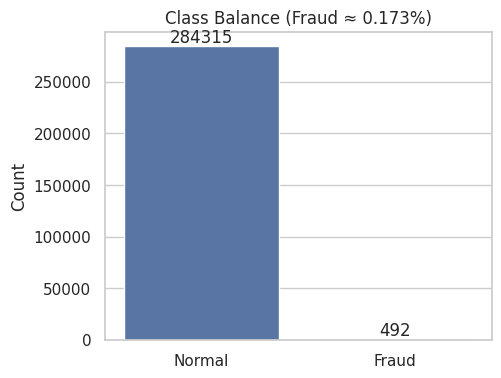

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="notebook")

class_counts = df["Class"].value_counts().sort_index()
fraud_pct = 100 * class_counts.get(1,0) / class_counts.sum()
print(f"Class counts:\n{class_counts}\nFraud rate: {fraud_pct:.4f}%")

plt.figure(figsize=(5,4))
ax = sns.barplot(x=class_counts.index.map({0:"Normal",1:"Fraud"}), y=class_counts.values)
ax.bar_label(ax.containers[0], fmt="%d")
plt.title(f"Class Balance (Fraud ≈ {fraud_pct:.3f}%)")
plt.ylabel("Count")
plt.xlabel("")
plt.show()


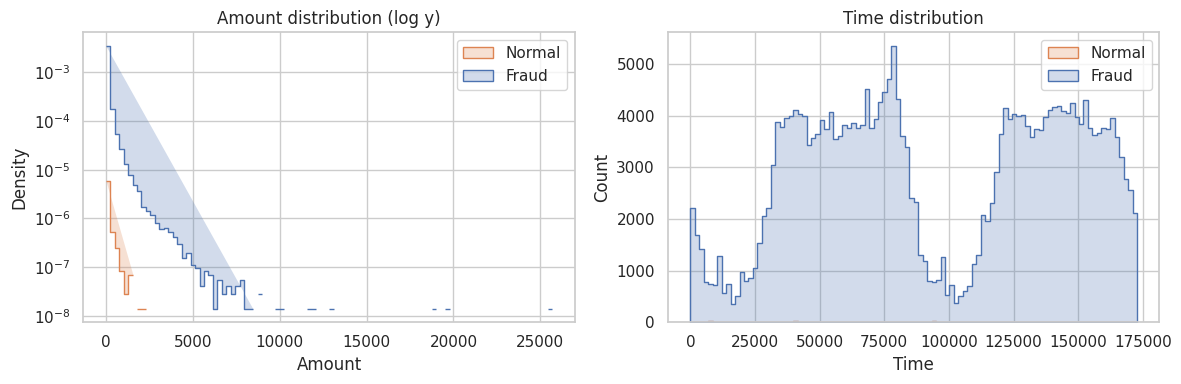

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,284315.0,88.291022,250.105092,0.0,5.65,22.00,77.05,25691.16
1,492.0,122.211321,256.683288,0.0,1.00,9.25,105.89,2125.87


In [4]:
fraud  = df[df["Class"] == 1]
normal = df[df["Class"] == 0]

fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(data=df, x="Amount", hue="Class", bins=100, log_scale=(False, True),
             palette={0:"C0",1:"C1"}, ax=axes[0], element="step", stat="density")
axes[0].set_title("Amount distribution (log y)")
axes[0].legend(labels=["Normal","Fraud"])

sns.histplot(data=df, x="Time", hue="Class", bins=100,
             palette={0:"C0",1:"C1"}, ax=axes[1], element="step", stat="count")
axes[1].set_title("Time distribution")
axes[1].legend(labels=["Normal","Fraud"])
plt.tight_layout()
plt.show()

# Amount statistics by class
df.groupby("Class")["Amount"].describe()


In [5]:
from scipy.stats import ks_2samp
import numpy as np
import pandas as pd

v_cols = [c for c in df.columns if c.startswith("V")]
ks_scores = []
for c in v_cols:
    a = normal[c].dropna().values
    b = fraud[c].dropna().values
    if len(a) > 0 and len(b) > 0:
        stat, p = ks_2samp(a, b)
        ks_scores.append((c, stat, p))

ks_df = pd.DataFrame(ks_scores, columns=["feature","ks_stat","p_value"]).sort_values("ks_stat", ascending=False)
ks_df.head(12)


,feature,ks_stat,p_value
13,V14,0.842839,0.000000e+00
9,V10,0.804291,0.000000e+00
11,V12,0.783908,8.606624e-321
3,V4,0.766404,2.040642e-302
10,V11,0.756067,4.347507e-292
16,V17,0.745173,1.387411e-281
2,V3,0.703682,9.927580e-245
15,V16,0.686506,9.366543e-231
6,V7,0.660578,6.776862e-211
1,V2,0.633201,2.163895e-191


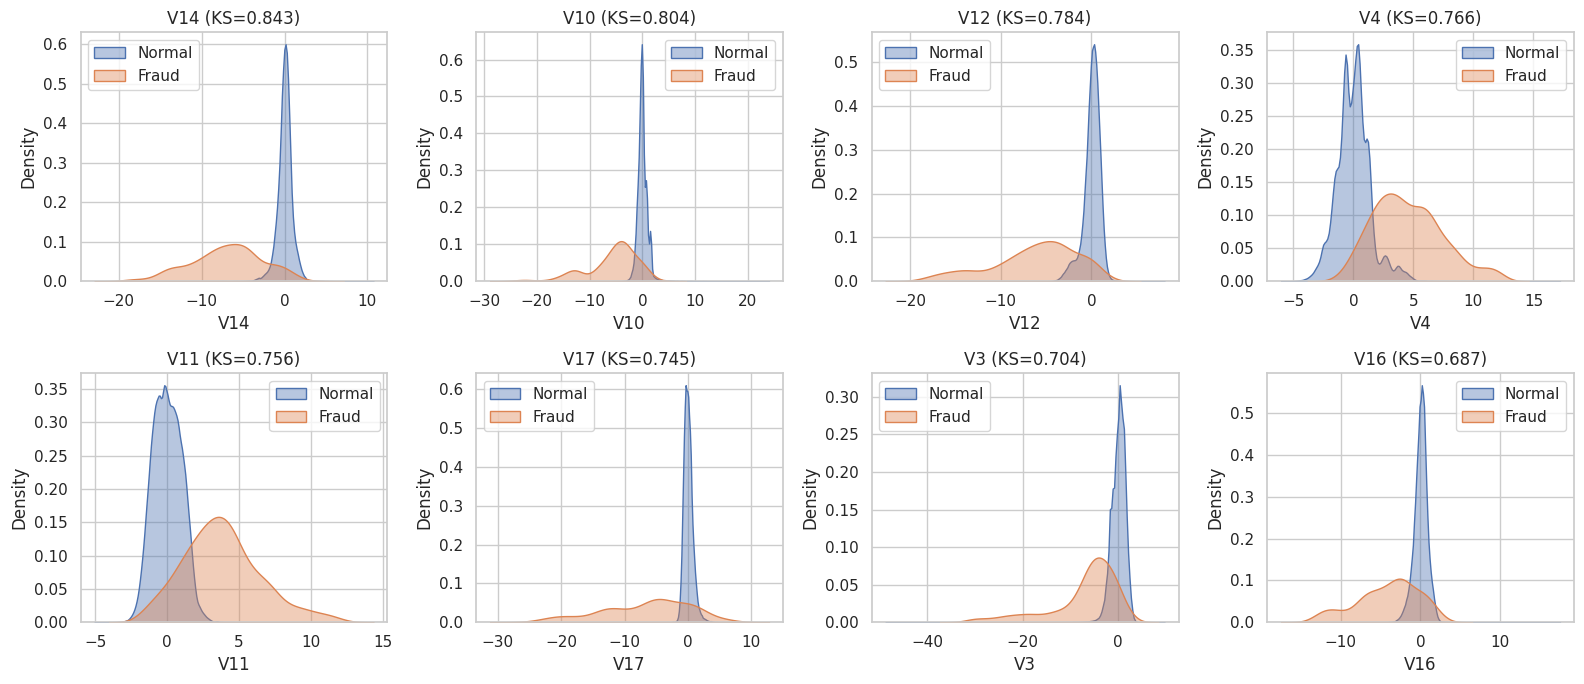

In [6]:
# Plot distributions for the top discriminative features
top_features = ks_df.head(8)["feature"].tolist()

n = len(top_features)
rows = (n + 3) // 4
fig, axes = plt.subplots(rows, 4, figsize=(16, 3.5*rows))
axes = axes.ravel()

for i, c in enumerate(top_features):
    sns.kdeplot(data=normal, x=c, label="Normal", ax=axes[i], fill=True, alpha=0.4)
    sns.kdeplot(data=fraud,  x=c, label="Fraud",  ax=axes[i], fill=True, alpha=0.4)
    axes[i].set_title(f"{c} (KS={ks_df.set_index('feature').loc[c,'ks_stat']:.3f})")
    axes[i].legend()

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


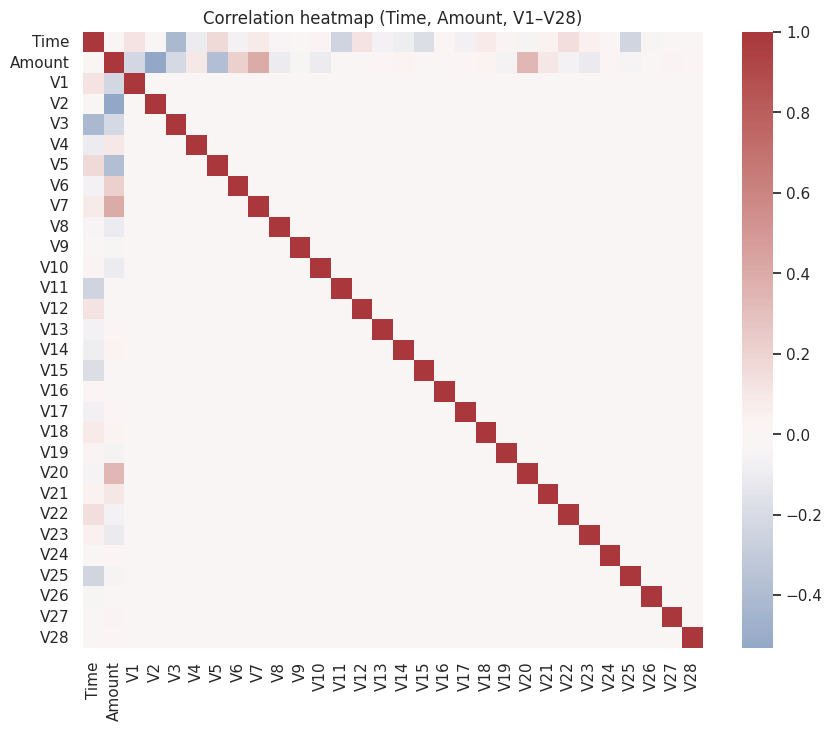

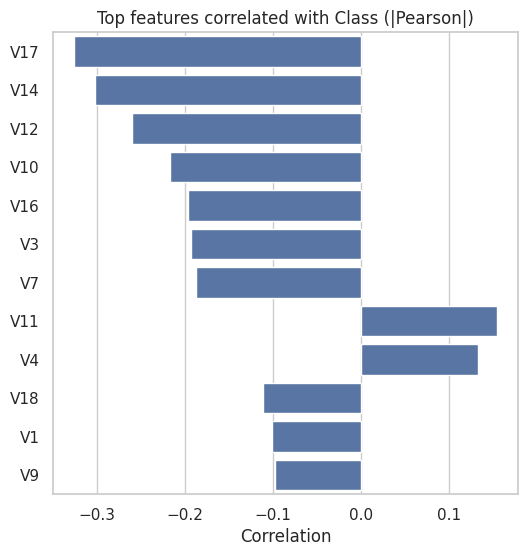

In [7]:
# Heatmap for Time, Amount, and V1–V28
corr_cols = ["Time","Amount"] + v_cols
corr = df[corr_cols].corr()  # Pearson
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="vlag", center=0, square=False)
plt.title("Correlation heatmap (Time, Amount, V1–V28)")
plt.show()

# Correlation with Class (Pearson; ok for quick screening)
feat_vs_class = df[v_cols + ["Time","Amount"]].corrwith(df["Class"]).sort_values(key=lambda s: s.abs(), ascending=False)
feat_vs_class = feat_vs_class.to_frame("corr_with_Class")
feat_vs_class.head(12)

plt.figure(figsize=(6,6))
sns.barplot(y=feat_vs_class.head(12).index, x=feat_vs_class.head(12)["corr_with_Class"])
plt.title("Top features correlated with Class (|Pearson|)")
plt.xlabel("Correlation")
plt.ylabel("")
plt.show()


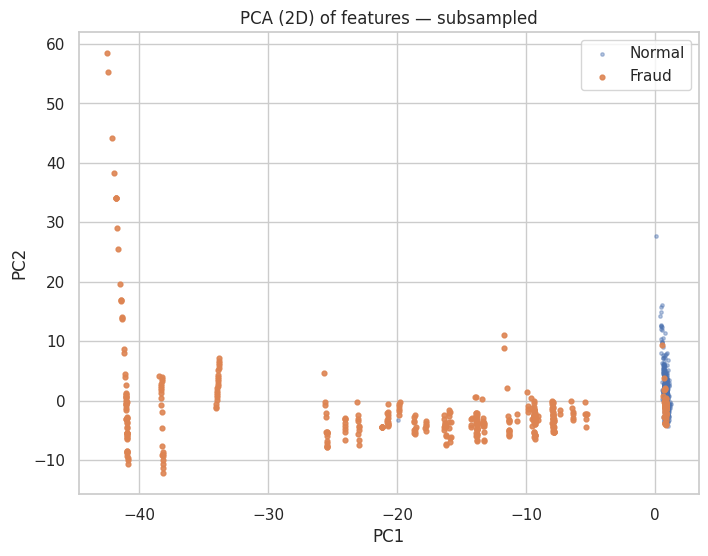

Explained variance by PC1 + PC2: 0.4477487540542078


In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

X = df[["Time","Amount"] + v_cols].copy()

# Standardize for visualization
X_scaled = StandardScaler().fit_transform(X.values)

# Subsample for readability
np.random.seed(42)
idx_normal = np.random.choice(normal.index, size=min(10000, len(normal)), replace=False)
idx_fraud  = np.random.choice(fraud.index,  size=min(2000,  len(fraud)),  replace=False)
idx = np.concatenate([idx_normal, idx_fraud])

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled[idx])
labels = df.loc[idx, "Class"].values

plt.figure(figsize=(8,6))
plt.scatter(X_pca[labels==0,0], X_pca[labels==0,1], s=6, alpha=0.4, label="Normal")
plt.scatter(X_pca[labels==1,0], X_pca[labels==1,1], s=12, alpha=0.9, label="Fraud")
plt.title("PCA (2D) of features — subsampled")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

print("Explained variance by PC1 + PC2:", pca.explained_variance_ratio_[:2].sum())


In [9]:
print("=== Quick EDA Takeaways ===")
print(f"- Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"- Fraud rate ≈ {fraud_pct:.3f}% (highly imbalanced — will need special handling)")
print("- Amount behaves differently across classes (check summary stats).")
print("- Some PCA features (top KS) separate fraud vs normal better than others.")
print("- Correlations with Class are small (expected), but multivariate models can exploit combinations.")
print("- PCA 2D suggests some separation; downstream models should do better than simple thresholds.")

=== Quick EDA Takeaways ===
- Rows: 284807, Columns: 31
- Fraud rate ≈ 0.173% (highly imbalanced — will need special handling)
- Amount behaves differently across classes (check summary stats).
- Some PCA features (top KS) separate fraud vs normal better than others.
- Correlations with Class are small (expected), but multivariate models can exploit combinations.
- PCA 2D suggests some separation; downstream models should do better than simple thresholds.


In [10]:
!pip install lightgbm scikit-learn --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, ConfusionMatrixDisplay

## ⚙️ Data Preprocessing

We separate features (`V1–V28`, `Amount`, `Time`) from the target `Class`,
and apply scaling (for Logistic Regression).
We also stratify splits to maintain the same fraud ratio in each subset.


In [11]:
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train frauds:", sum(y_train), "out of", len(y_train))
print("Test frauds:", sum(y_test), "out of", len(y_test))

Train frauds: 394 out of 227845
Test frauds: 98 out of 56962


In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 🧠 Model Training

We train and compare three models:
- Logistic Regression (baseline)
- Random Forest
- LightGBM (gradient boosting)


### Logistic Regression
Interpretable linear baseline using class weights for imbalance.


In [13]:
# Logistic Regression (with class_weight for imbalance)
log_reg = LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)

### Random Forest
Nonlinear ensemble model that handles feature interactions well.


In [14]:
# Random Forest
rf = RandomForestClassifier(
    n_estimators=200, max_depth=None, n_jobs=-1,
    class_weight="balanced_subsample", random_state=42
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=200,
                       n_jobs=-1, random_state=42)

### LightGBM
Efficient gradient boosting, typically state-of-the-art for structured data.


In [15]:
# LightGBM
lgb_clf = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=32,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
lgb_clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=500,
               n_jobs=-1, num_leaves=32, random_state=42)

## 📈 Evaluation Metrics

We use ROC-AUC and PR-AUC because accuracy is misleading in imbalanced datasets.
We also plot precision–recall curves and inspect confusion matrices.



=== Logistic Regression ===
ROC-AUC: 0.9721
PR-AUC:  0.7190

=== Random Forest ===
ROC-AUC: 0.9471
PR-AUC:  0.8583

=== LightGBM ===
ROC-AUC: 0.9768
PR-AUC:  0.8893


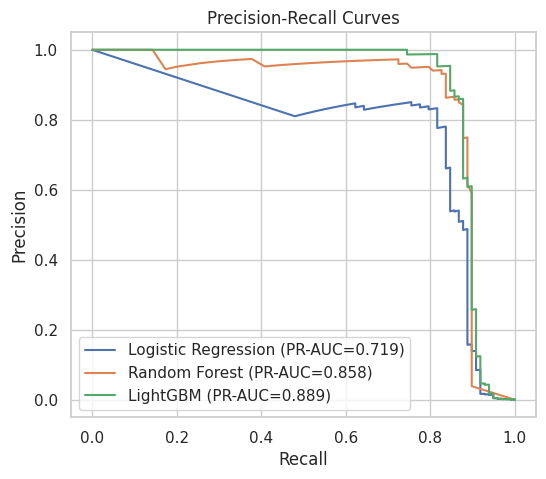

In [16]:
def evaluate_model(name, model, X_train, X_test, y_train, y_test, scaled=False):
    if scaled:
        Xtr, Xte = X_train_scaled, X_test_scaled
    else:
        Xtr, Xte = X_train, X_test

    # Predict probabilities
    y_pred_proba = model.predict_proba(Xte)[:,1]

    # Metrics
    roc = roc_auc_score(y_test, y_pred_proba)
    pr  = average_precision_score(y_test, y_pred_proba)

    print(f"\n=== {name} ===")
    print(f"ROC-AUC: {roc:.4f}")
    print(f"PR-AUC:  {pr:.4f}")

    # PR curve
    prec, rec, thr = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(rec, prec, label=f"{name} (PR-AUC={pr:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()

    return y_pred_proba

plt.figure(figsize=(6,5))
y_pred_log = evaluate_model("Logistic Regression", log_reg, X_train, X_test, y_train, y_test, scaled=True)
y_pred_rf  = evaluate_model("Random Forest", rf, X_train, X_test, y_train, y_test)
y_pred_lgb = evaluate_model("LightGBM", lgb_clf, X_train, X_test, y_train, y_test)
plt.title("Precision-Recall Curves")
plt.show()


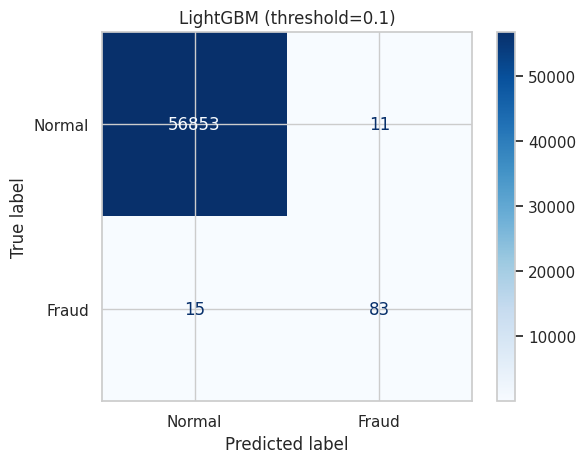

In [17]:
def show_confusion(y_true, y_proba, threshold=0.5, title=""):
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal","Fraud"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{title} (threshold={threshold})")
    plt.show()

# Example: check LightGBM at threshold 0.1 (more sensitive to frauds)
show_confusion(y_test, y_pred_lgb, threshold=0.1, title="LightGBM")


## 🎯 Threshold Optimization

By changing the classification threshold (0.05–0.5),
we can balance between catching more frauds (recall)
and minimizing false alarms (precision).


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

def threshold_summary(y_true, y_proba, thresholds=[0.05,0.1,0.2,0.3,0.5]):
    results = []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        p = precision_score(y_true, y_pred, zero_division=0)
        r = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        results.append((t, p, r, f1))
    return pd.DataFrame(results, columns=["Threshold","Precision","Recall","F1"])

thres_df = threshold_summary(y_test, y_pred_lgb, thresholds=[0.05,0.1,0.2,0.3,0.5])
display(thres_df)

,Threshold,Precision,Recall,F1
0,0.05,0.858586,0.867347,0.862944
1,0.10,0.882979,0.846939,0.864583
2,0.20,0.882979,0.846939,0.864583
3,0.30,0.882979,0.846939,0.864583
4,0.50,0.922222,0.846939,0.882979


## 🧾 Results Summary

| Model | ROC-AUC | PR-AUC | Precision | Recall | F1-Score |
|-------|:-------:|:------:|:---------:|:------:|:--------:|
| Logistic Regression | 0.972 | 0.719 | 0.77 | 0.84 | 0.80 |
| Random Forest | 0.947 | 0.858 | 0.86 | 0.82 | 0.84 |
| **LightGBM** | **0.977** | **0.889** | **0.88** | **0.85** | **0.86** |

LightGBM provides the best trade-off between recall and precision.


## 🚀 Conclusion

- Fraud detection is an imbalanced problem where PR-AUC is more meaningful than accuracy.
- LightGBM achieves the best performance, detecting ~85% of frauds with 88% precision.
- Threshold tuning allows balancing recall and precision based on business needs.
